In [234]:
import time
import random
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

Target reached at 7.10%


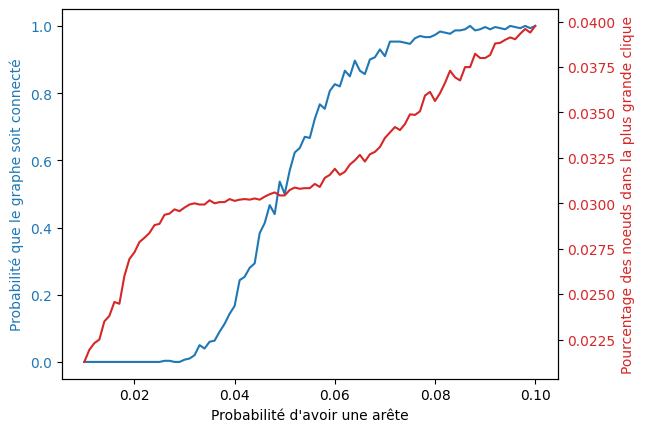

In [40]:
def q1():
    n_nodes = 100
    n_iterations = 300 # Generally 200 is enough
    increment = .001
    prob_max = 0.1
    
    connection_prob_target = 0.95
    has_reached_target = False
    x_reached_target = None
    
    x = np.arange(0.01, prob_max, increment)
    graph_connections = np.zeros(len(x))
    graph_max_cliques = np.zeros(len(x))
    
    # For each edge probability
    for i, edge_prob in enumerate(x):
        sum, max_clique_sum = 0, 0
        
        # Calculate many graph connections
        for j in range(0, n_iterations):
            graph = nx.fast_gnp_random_graph(n_nodes, edge_prob)
            sum += nx.is_connected(graph)
            clique_max = max(len(clique) for clique in nx.find_cliques(graph))
            max_clique_sum += clique_max / n_nodes
            
        # Calculate average graph connection
        avg_connection = sum / n_iterations
        avg_max_clique = max_clique_sum / n_iterations
        
        # Check if the target has been reached
        if avg_connection >= connection_prob_target and not has_reached_target:
            print(f"Target reached at {edge_prob:.2%}")
            x_reached_target = i
            has_reached_target = True
        
        graph_connections[i] = avg_connection
        graph_max_cliques[i] = avg_max_clique
    
        # if (edge_prob/prob_max*100) % 10 == 0: print(f"{edge_prob/prob_max:.0%}", end=" ")
        
    color = 'tab:blue'
    fig, ax1 = plt.subplots()
    ax1.set_xlabel('Probabilité d\'avoir une arête')
    ax1.set_ylabel('Probabilité que le graphe soit connecté', color=color)
    ax1.plot(x, graph_connections, color=color)
    ax1.tick_params(axis='y', labelcolor=color)
    
    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Proportion des noeuds dans la plus grande clique', color=color)
    ax2.plot(x, graph_max_cliques, color=color)
    ax2.tick_params(axis='y', labelcolor=color)

    plt.show()
    
q1()

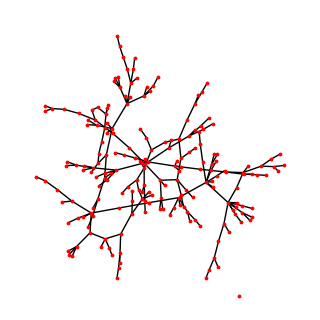

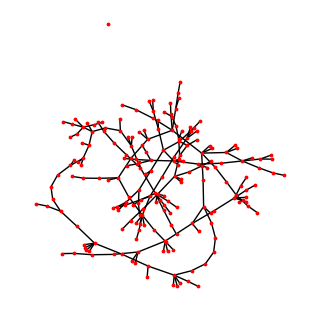

Pourcentage de graphe connectés: 0%
Longueur moyenne des graphe connectés : nan


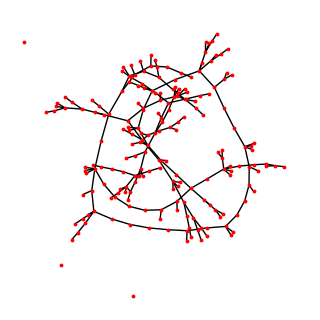

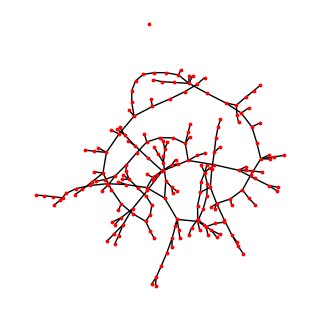

Pourcentage de graphe connectés: 0%
Longueur moyenne des graphe connectés : nan


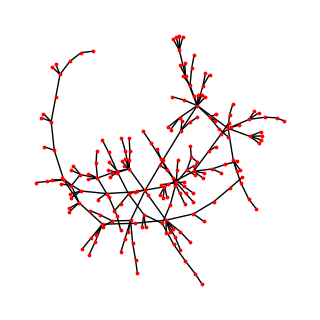

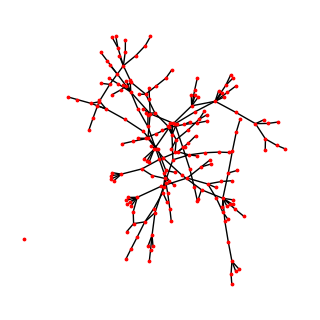

Pourcentage de graphe connectés: 50%
Longueur moyenne des graphe connectés : 13.52


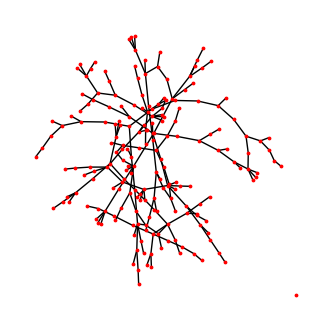

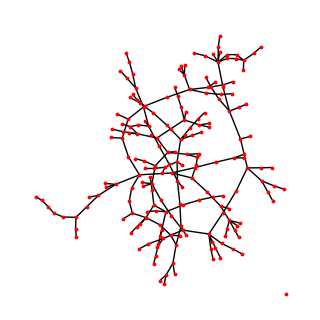

Pourcentage de graphe connectés: 0%
Longueur moyenne des graphe connectés : nan


In [271]:
import time

# Check if a node still has a timer > 0
def timers_are_done(graph):
    for node in graph.nodes:
        if graph.nodes[node]['timer'] > 0: return False
    return True

def draw_graph(graph):
    plt.figure(figsize=(3, 3))
    nx.draw(graph, node_size=3, node_color='red')
    plt.show()

def get_infos(graph, i, divergence):
    # Get the neighbors of the node
    neighbors = graph.neighbors(i)
    
    # Get all nodes except the specified node and its direct neighbors
    others = set(graph.nodes) - set([i] + list(neighbors))
    
    # If there are no other nodes, stop
    # This should never happen
    if others == set():
        draw_graph(graph)
        print("No other nodes")
        raise Exception("No other nodes")
        
    # Get other node with the highest value, with a random factor
    best_node = sorted(
        others,
        key=lambda x: graph.nodes[x]['value'] * random.uniform(1-divergence, 1+divergence),
        reverse=True
    )[0]
    return neighbors, others, best_node
    
def successive_edge_addition(graph, update_best_node, divergence):
    for i, node in graph.nodes(data=True):
        # Skip if timer is 0
        # TODO : Regarder ce qui se passe en remplaçant <= par <
        if node['timer'] <= 0: continue
        
        # Decrement the timer if successive
        node['timer'] -= 1
        
        # Skip if timer is not 0
        if node['timer'] > 0: continue
        
        try:
            neighbors, others, best_node = get_infos(graph, i, divergence)
        except:
            break
    
        # Add new edge to the node with the highest value
        graph.add_edge(i, best_node)
        graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        
        if update_best_node: graph.nodes[best_node]['value'] += 1
        
    return graph

def simultaneous_edge_addition(graph, update_best_node, divergence):
    for node in graph.nodes: graph.nodes[node]['timer'] -= 1
    
    # List of nodes (only ids) to update (where the time is 0)
    nodes_to_update = set(node for node in graph.nodes if graph.nodes[node]['timer'] == 0)
    # Future graph
    next_graph = graph.copy()
    
    
    # Update each node independently
    for i in nodes_to_update:
        
        try:
            neighbors, others, best_node = get_infos(graph, i, divergence)
        except:
            break
        
        # Update next graph
        next_graph.add_edge(i, best_node)
        next_graph.nodes[i]['value'] = graph.nodes[best_node]['value'] + 1
        if update_best_node: next_graph.nodes[best_node]['value'] += 1
        
    return next_graph
    
def perform(n_nodes, successive, update_best_node, divergence):
    graph = nx.empty_graph(n_nodes,create_using=nx.Graph())

    # Creating graph with n_nodes nodes, each node has a random position and a random timer
    for i in range(n_nodes):
        graph.add_node(i, timer=np.random.randint(0, n_nodes), value=0)
        
    while not timers_are_done(graph):
        # TODO : Est-ce que les timer égaux s'activent successivement ou simultanément ?
        # TODO : Est-ce que la valeur des voisins s'actualisent quand on ajoute un edge ?
        if successive:
            graph = successive_edge_addition(graph, update_best_node, divergence)
        else:
            graph = simultaneous_edge_addition(graph, update_best_node, divergence)
    
    return graph
        
    
def q2(n_iterations, n_nodes, successive=False, update_best_node=False, draw=False, divergence=0):
    graph_connections = np.zeros(n_iterations)
    avg_shortest_paths = []
    
    for i in range(n_iterations):
        graph = perform(n_nodes, successive, update_best_node, divergence)
        
        is_connected = nx.is_connected(graph)
        graph_connections[i] = is_connected
        
        # print("Connected" if is_connected else "Not connected")
        if is_connected:
            avg_shortest_paths.append(nx.average_shortest_path_length(graph))
            # print(f"Average shortest path length : {nx.average_shortest_path_length(graph)}")
            
        if draw: 
            draw_graph(graph)
            time.sleep(1)
    
    print(f"Pourcentage de graphe connectés: {graph_connections.mean():.0%}")
    print(f"Longueur moyenne des graphe connectés : {np.mean(avg_shortest_paths):.2f}")

q2(2, 200, successive=True, update_best_node=True, draw=True, divergence=0.5)
q2(2, 200, successive=True, update_best_node=False, draw=True, divergence=0.5)
q2(2, 200, successive=False, update_best_node=True, draw=True, divergence=0.5)
q2(2, 200, successive=False, update_best_node=False, draw=True, divergence=0.5)